In [1]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from matplotlib import cm
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, trigger_onset

In [2]:
data_directory = '../../../data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed'
mseed_file = f'{data_directory}'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-01-19T00:00:00.665000Z - 1970-01-20T00:00:02.778208Z | 6.6 Hz, 572415 samples

In [3]:
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

In [4]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 4

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

c:\Users\hombr\AppData\Local\Programs\Python\Python312\Lib\site-packages\obspy\signal\filter.py:62: UserWarning: Selected high corner frequency (4) of bandpass is at or above Nyquist (3.3125). Applying a high-pass instead.
  warnings.warn(msg)


In [5]:
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

C:\Users\hombr\AppData\Local\Temp\ipykernel_10300\926705533.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


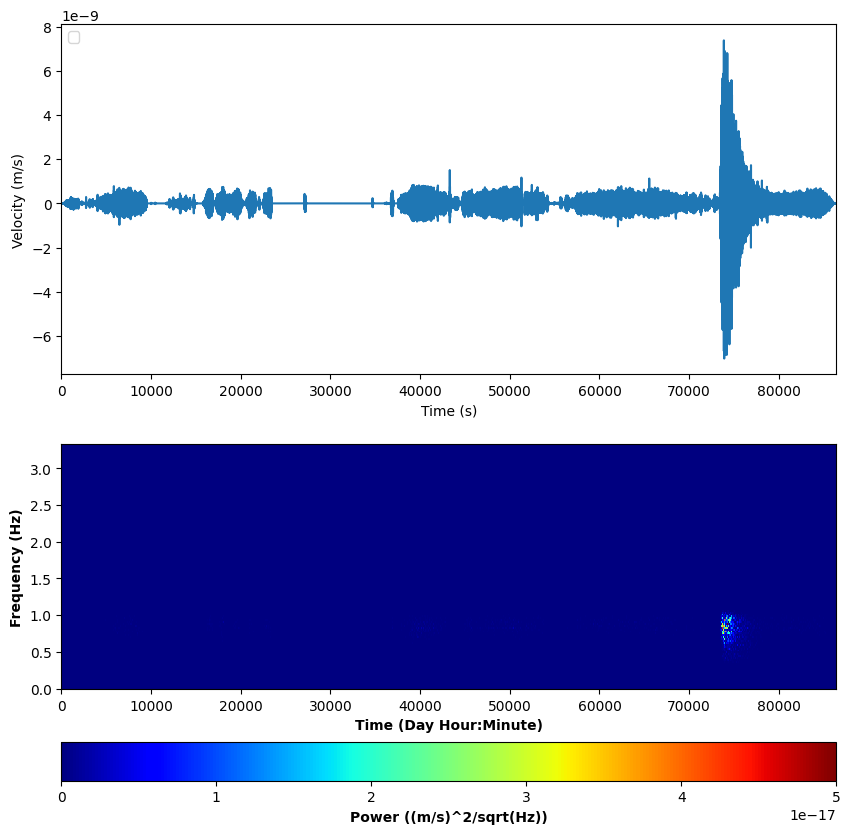

In [6]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

ax.legend(loc='upper left')
# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

c:\Users\hombr\AppData\Local\Programs\Python\Python312\Lib\site-packages\obspy\signal\filter.py:62: UserWarning: Selected high corner frequency (4.0) of bandpass is at or above Nyquist (3.3125). Applying a high-pass instead.
  warnings.warn(msg)


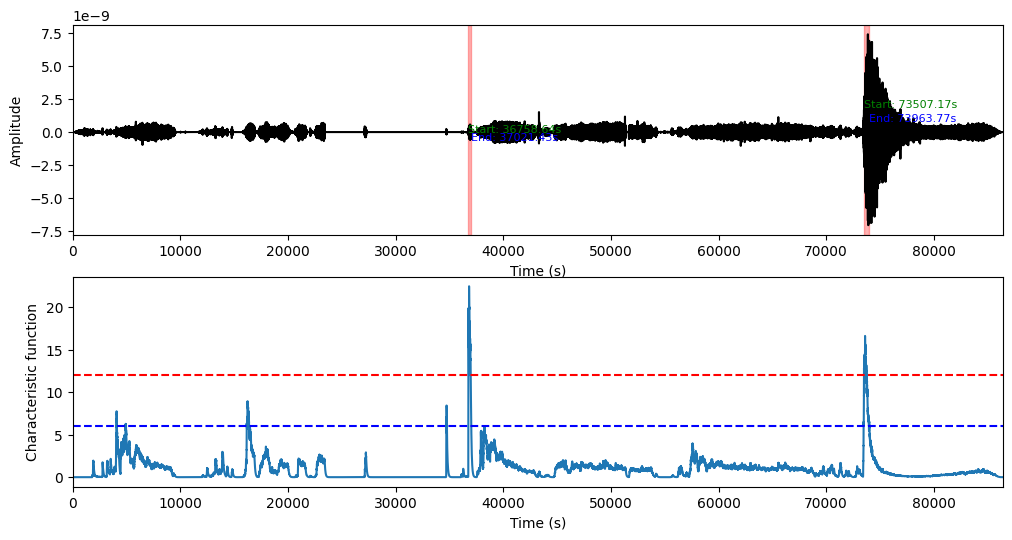

In [7]:
from obspy.signal.trigger import recursive_sta_lta, trigger_onset
import matplotlib.pyplot as plt
import numpy as np

# Frecuencia de muestreo de la traza
df = tr.stats.sampling_rate

# Aplicar un filtro de banda antes del análisis
tr.filter('bandpass', freqmin=0.5, freqmax=4.0)  # Ajustar el filtro de banda

# Longitudes de ventana STA/LTA en segundos
sta_len = 60   # Ventana de corto plazo
lta_len = 1800  # Ventana de largo plazo

# Ejecutar STA/LTA recursivo
cft = recursive_sta_lta(tr.data, int(sta_len * df), int(lta_len * df))

# Definir umbrales para la detección (ajustados)
threshold_on = 12.0  # Incrementar umbral de activación
threshold_off = 6.0  # Incrementar umbral de desactivación

# Detectar eventos
on_off = trigger_onset(cft, threshold_on, threshold_off)

# Filtrar detecciones cortas (menos de 60 segundos)
min_duration = 60 * df
on_off_filtered = [event for event in on_off if (event[1] - event[0]) > min_duration]

# Fusionar detecciones cercanas (si la diferencia entre ellas es menor a un cierto tiempo)
min_gap = 5000  # Número de muestras entre eventos detectados para fusionarlos
merged_on_off = []
if len(on_off_filtered) > 0:
    current_event = on_off_filtered[0]
    for i in range(1, len(on_off_filtered)):
        if on_off_filtered[i][0] - current_event[1] < min_gap:
            current_event[1] = on_off_filtered[i][1]  # Fusionar eventos
        else:
            merged_on_off.append(current_event)
            current_event = on_off_filtered[i]
    merged_on_off.append(current_event)

# Visualizar la función característica y las detecciones
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Gráfico de la señal con detecciones
ax[0].plot(tr.times(), tr.data, 'k')
for start, end in merged_on_off:
    # Convertir índices a tiempo en segundos
    start_time = start / df
    end_time = end / df
    
    # Resaltar el intervalo detectado
    ax[0].axvspan(tr.times()[start], tr.times()[end], color='red', alpha=0.3)
    
    # Anotar el tiempo de inicio y fin
    ax[0].text(tr.times()[start], tr.data[start], f'Start: {start_time:.2f}s', color='green', fontsize=8, verticalalignment='bottom')
    ax[0].text(tr.times()[end], tr.data[end], f'End: {end_time:.2f}s', color='blue', fontsize=8, verticalalignment='top')

ax[0].set_xlim([min(tr.times()), max(tr.times())])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

# Gráfico de la función característica STA/LTA
ax[1].plot(tr.times(), cft)
ax[1].axhline(y=threshold_on, color='r', linestyle='--')
ax[1].axhline(y=threshold_off, color='b', linestyle='--')
ax[1].set_xlim([min(tr.times()), max(tr.times())])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Characteristic function')

plt.show()


In [8]:
i=0
for start_test,end_test in merged_on_off:
    i+=1
    print(f'{i}. Event detected at {start_test/df} s and ended at {end_test/df} s')

1. Event detected at 36758.64150943396 s and ended at 37021.43396226415 s
2. Event detected at 73507.16981132075 s and ended at 73963.77358490566 s
